In [1]:
import pandas as pd 
import janitor

def get_data():
    URL_CSV="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
    df = pd.read_csv(URL_CSV)
    df['Country/Region'] = df['Country/Region'].replace({'US':'United States of America'})
    return df
df = get_data()
df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,11/12/20,11/13/20,11/14/20,11/15/20,11/16/20,11/17/20,11/18/20,11/19/20,11/20/20,11/21/20
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,42795,42969,43035,43240,43403,43628,43851,44228,44443,44503
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,26211,26701,27233,27830,28432,29126,29837,30623,31459,32196
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,65108,65975,66819,67679,68589,69591,70629,71652,72755,73774
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,5616,5725,5725,5872,5914,5951,6018,6066,6142,6207
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,13053,13228,13374,13451,13615,13818,13922,14134,14267,14413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,60784,61514,62167,63031,63867,64935,66186,67296,68768,70254
265,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,10,10,10,10,10,10,10,10,10,10
266,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,2071,2072,2072,2072,2078,2081,2083,2086,2090,2093
267,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,17056,17093,17097,17123,17187,17243,17280,17350,17373,17394


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2,2020-01-24,-1.871279e+04,0.000000e+00,6.663466e+05,-1.871279e+04,-1.871279e+04,39490.430903,39490.430903,39490.430903,39490.430903,39490.430903,39490.430903,0.0,0.0,0.0,2.077765e+04
3,2020-01-25,-1.543856e+04,0.000000e+00,6.878036e+05,-1.543856e+04,-1.543856e+04,46054.303067,46054.303067,46054.303067,46054.303067,46054.303067,46054.303067,0.0,0.0,0.0,3.061575e+04
8,2020-01-30,9.325821e+02,0.000000e+00,7.193152e+05,9.325821e+02,9.325821e+02,11578.616557,11578.616557,11578.616557,11578.616557,11578.616557,11578.616557,0.0,0.0,0.0,1.251120e+04
9,2020-01-31,4.206810e+03,0.000000e+00,6.638093e+05,4.206810e+03,4.206810e+03,39490.430903,39490.430903,39490.430903,39490.430903,39490.430903,39490.430903,0.0,0.0,0.0,4.369724e+04
10,2020-02-01,7.481038e+03,0.000000e+00,6.668543e+05,7.481038e+03,7.481038e+03,46054.303067,46054.303067,46054.303067,46054.303067,46054.303067,46054.303067,0.0,0.0,0.0,5.353534e+04
14,2020-02-05,2.057795e+04,0.000000e+00,6.174278e+05,2.057795e+04,2.057795e+04,-12236.540002,-12236.540002,-12236.540002,-12236.540002,-12236.540002,-12236.540002,0.0,0.0,0.0,8.341405e+03
15,2020-02-06,2.385217e+04,0.000000e+00,6.579536e+05,2.385217e+04,2.385217e+04,11578.616557,11578.616557,11578.616557,11578.616557,11578.616557,11578.616557,0.0,0.0,0.0,3.543079e+04
16,2020-02-07,2.712640e+04,0.000000e+00,6.675526e+05,2.712640e+04,2.712640e+04,39490.430903,39490.430903,39490.430903,39490.430903,39490.430903,39490.430903,0.0,0.0,0.0,6.661683e+04
17,2020-02-08,3.040063e+04,0.000000e+00,7.691586e+05,3.040063e+04,3.040063e+04,46054.303067,46054.303067,46054.303067,46054.303067,46054.303067,46054.303067,0.0,0.0,0.0,7.645493e+04
18,2020-02-09,3.367485e+04,0.000000e+00,6.682820e+05,3.367485e+04,3.367485e+04,-25394.551098,-25394.551098,-25394.551098,-25394.551098,-25394.551098,-25394.551098,0.0,0.0,0.0,8.280301e+03


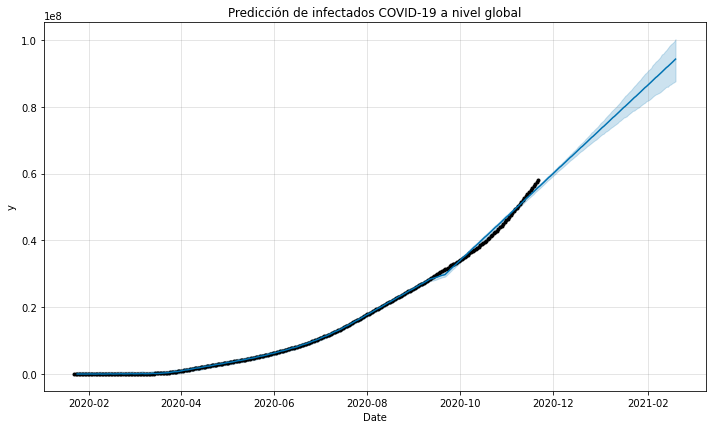

In [2]:
import janitor
import pandas as pd
import pandas_flavor as pf
import fbprophet
from matplotlib import pyplot as plt    
from IPython.display import display, HTML



LISTA_COLUMNAS_A_BORRAR = ['Province/State', 'Country/Region', 'Lat', 'Long']



df = get_data()
df = df.remove_columns(LISTA_COLUMNAS_A_BORRAR)
df
df = pd.DataFrame( df.sum())
df.columns=['y']
df.index = pd.to_datetime(df.index)  
df['ds'] = df.index
df = df.reset_index()


df = df.remove_columns(['index'])


df_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
df_prophet.fit(df)

df_forecast = df_prophet.make_future_dataframe(periods=90, freq='D')
# Make predictions
df_forecast = df_prophet.predict(df_forecast)
df_forecast

df_forecast = df_forecast[df_forecast["yhat"] >= 0]
df_forecast.loc[df_forecast.yhat_lower < 0, 'yhat_lower'] = 0


df_prophet.plot(df_forecast, xlabel = 'Date' )
plt.title('Predicción de infectados COVID-19 a nivel global'   )

display(HTML(pd.DataFrame(df_forecast).to_html()))


In [3]:
df = get_data()
df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,11/12/20,11/13/20,11/14/20,11/15/20,11/16/20,11/17/20,11/18/20,11/19/20,11/20/20,11/21/20
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,42795,42969,43035,43240,43403,43628,43851,44228,44443,44503
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,26211,26701,27233,27830,28432,29126,29837,30623,31459,32196
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,65108,65975,66819,67679,68589,69591,70629,71652,72755,73774
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,5616,5725,5725,5872,5914,5951,6018,6066,6142,6207
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,13053,13228,13374,13451,13615,13818,13922,14134,14267,14413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,60784,61514,62167,63031,63867,64935,66186,67296,68768,70254
265,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,10,10,10,10,10,10,10,10,10,10
266,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,2071,2072,2072,2072,2078,2081,2083,2086,2090,2093
267,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,17056,17093,17097,17123,17187,17243,17280,17350,17373,17394


In [4]:

import janitor
import datetime
import numpy as np

def pipeline_populations():
    """ Cogemos un dataframe de poblaciones"""

    URL="https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/CSV_FILES/WPP2019_TotalPopulationBySex.csv"
    THIS_YEAR = datetime.datetime.now().year

    return (
        pd.read_csv(URL)
        .filter_on( f""" Time  ==  {THIS_YEAR} & Variant == "Medium" """ ) 
        .select_columns(['Location','PopTotal'])
        .join_apply(lambda x: x['PopTotal'] * 1000 , new_column_name="PopMillions" )
        .remove_columns(['PopTotal'])
        .rename_column('PopMillions' , 'PopTotal')
        .transform_column('PopTotal',np.int64)
        .rename_column('Location' , 'Country/Region')
    )


populations = pipeline_populations()
populations

,Country/Region,PopTotal
70,Afghanistan,38928341
954,Africa,1340598113
1838,African Group,1338826591
1989,African Union,1339423920
2140,African Union: Central Africa,158619638
...,...,...
277315,World,7794798728
278199,World Bank Regional Groups (developing only),6528762227
278350,Yemen,29825967
279234,Zambia,18383956


In [5]:
df = get_data()
df_country = pd.DataFrame()
df_country['Country/Region'] = df['Country/Region']
df_country['infected last_day'] = df.iloc[:,-1] - df.iloc[:,-2]
df_country.set_index('Country/Region')
df_country

,Country/Region,infected last_day
0,Afghanistan,60
1,Albania,737
2,Algeria,1019
3,Andorra,65
4,Angola,146
...,...,...
264,West Bank and Gaza,1486
265,Western Sahara,0
266,Yemen,3
267,Zambia,21


In [6]:
df_country_enrich = pd.merge(df_country, populations, on="Country/Region")
df_country_enrich['Infected/Million'] =  1000000 * df_country_enrich['infected last_day'] / df_country_enrich['PopTotal'] 
df_country = df_country_enrich

In [7]:
df_country.sort_values(by='Infected/Million', ascending=False).head(10)

,Country/Region,infected last_day,PopTotal,Infected/Million
122,Georgia,3824,3989175,958.594196
169,Montenegro,574,628062,913.922511
89,Croatia,3573,4105268,870.345127
3,Andorra,65,77265,841.260597
209,Slovenia,1704,2078932,819.651629
16,Austria,6611,9006400,734.033576
155,Lithuania,1983,2722290,728.430843
204,Serbia,5774,8737370,660.839589
192,Poland,24213,37846605,639.766764
193,Portugal,6472,10196707,634.714717


In [8]:
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.dates as mdates


def pintar_grafico(df, array_naciones_pintar ,title):
    df = df.T
    df = df.iloc[1:]
    new_header = df.iloc[0] #grab the first row for the header
    df = df[1:] #take the data less the header row
    df.columns = new_header #set the header row as the df header
    df = df.iloc[2:]
    df.index = pd.to_datetime(df.index)
    df = df[array_naciones_pintar]
    df = df.iloc[:, : 9]
    chart_df = df

    pd.plotting.register_matplotlib_converters()
    chart_df.plot(legend=True,figsize=(13.5,9))

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%B-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
    plt.xticks(rotation=45)

    ax = plt.gca()

    ax.set_title(title)
    ax.set_ylim(ymin=0)

    plt.show()

    #df.tail(30).style.format ({ c : "{:20,.0f}" for c in df.columns }).background_gradient(cmap='Wistia', )
    return plt 



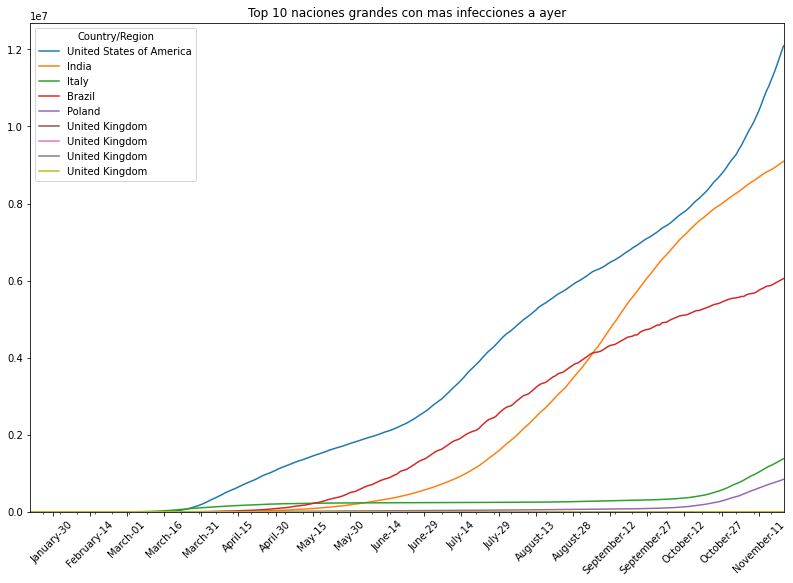

<module 'matplotlib.pyplot' from '/root/anaconda2/envs/jupyter/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [9]:
title="Top 10 naciones grandes con mas infecciones a ayer"
display(HTML(f"""<h1 id='{title}'>{title}</h1>"""))
df = get_data()

naciones_pintar = df_country.sort_values(by='infected last_day', ascending=False).head(10)['Country/Region'].values
df_country.sort_values(by='infected last_day', ascending=False).head(10)

pintar_grafico(df,naciones_pintar,title)



In [10]:
def pintar_grafico_daily(df, array_naciones_pintar ,title):
    df = df.T
    df = df.iloc[1:]
    new_header = df.iloc[0] #grab the first row for the header
    df = df[1:] #take the data less the header row
    df.columns = new_header #set the header row as the df header
    df = df.iloc[2:]
    df.index = pd.to_datetime(df.index)
    df = df[array_naciones_pintar]
    chart_df = df

    pd.plotting.register_matplotlib_converters()
    
    df_daily_increments = pd.DataFrame()
    for country in chart_df.columns:
        df_daily_increments[country] = chart_df[country].pct_change().rolling(window=7).mean()

    df_daily_increments    

    chart_df = df_daily_increments
    chart_df.tail(45).plot(legend=True,figsize=(13.5,9))

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%B-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
    plt.xticks(rotation=45)

    ax = plt.gca()

    ax.set_title(title)
    ax.set_ylim(ymin=0)

    plt.show()

    chart_df.tail(30).style.format ({ c : "{:20,.2f}" for c in df.columns }).background_gradient(cmap='Wistia', )


    return chart_df


#pintar_grafico_daily(df,naciones_pintar,"Top 10 countries more cases, daily percentage change")
df_country

,Country/Region,infected last_day,PopTotal,Infected/Million
0,Afghanistan,60,38928341,1.541294
1,Albania,737,2877800,256.098409
2,Algeria,1019,43851043,23.237760
3,Andorra,65,77265,841.260597
4,Angola,146,32866267,4.442245
...,...,...,...,...
244,Vanuatu,0,307150,0.000000
245,Western Sahara,0,597330,0.000000
246,Yemen,3,29825967,0.100583
247,Zambia,21,18383956,1.142300


In [11]:
#pintar_grafico_daily(df,naciones_pintar,"Top 10 countries more cases, daily percentage change")